In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import librosa, librosa.display
import sklearn
import keras
from keras.models import Model, Sequential, Input
from keras.layers import Conv2D
import keras.backend as K

Using TensorFlow backend.


# Verify that we are using the GPU

In [2]:
import tensorflow as tf
tf.test.is_gpu_available()

True

# Load in Data and peek at dataframe

1. 25863 mp3 mono audio files, each of 30 seconds long
2. 188 labels associated with each song

In [3]:
df = pd.read_csv("../annotations_final.csv",sep="\t")
df2=pd.read_csv("../clip_info_final.csv",sep="\t")

In [4]:
print(df.shape,df2.shape)

(25863, 190) (31382, 10)


In [5]:
df.head(10)

,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
5,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-30-59.mp3
6,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-175-204.mp3
7,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-233-262.mp3
8,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/lvx_nova-lvx_nova-01-contimune-291-320.mp3
9,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...


In [6]:
df2.head(6)

,clip_id,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url,mp3_path
0,2,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,30,59,http://he3.magnatune.com/all/01--BWV54%20-%20I...,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,146,175,http://he3.magnatune.com/all/01--BWV54%20-%20I...,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,262,291,http://he3.magnatune.com/all/01--BWV54%20-%20I...,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,291,320,http://he3.magnatune.com/all/01--BWV54%20-%20I...,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,320,349,http://he3.magnatune.com/all/01--BWV54%20-%20I...,f/american_bach_soloists-j_s__bach_solo_cantat...
5,14,1,Contimune,LVX Nova,LVX Nova,http://www.magnatune.com/artists/albums/lvxnov...,30,59,http://he3.magnatune.com/all/01--Contimune--LV...,c/lvx_nova-lvx_nova-01-contimune-30-59.mp3


# Ground truth Labels

In [7]:
y=df.values[:,1:-1]
#this y contains clip id as its first column
print(y,y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (25863, 188)


# Feature extraction

1. use feature extraction methods from VGGish, preprocess.py
2. perform transfer learning on VGGish network

In [8]:
#split dataset into train and test set
n=df.shape[0]
n_test=n//4
test_idx=np.arange(0,n_test)
train_idx=np.arange(n_test,n)
batch_size = 32

In [13]:
#this takes input as batch size and output the input batch and ground truth labels
def batchmatrix(batch_size,df,idx):
    #idx=np.arange(0,df.shape[0])
    np.random.shuffle(idx)
    idx_shuffled=idx[:batch_size]
    batchmatrix=np.zeros((batch_size,96,64))
    batchy=np.zeros((batch_size,188))
    for m,i in enumerate(idx_shuffled):
        x,fs=librosa.load(df["mp3_path"][i])
        X=preprocess_sound.preprocess_sound(x, fs)
        X_slice=X[random.randint(0,X.shape[0]-1),:,:]
        batchmatrix[m,:,:]=X_slice
        batchy[m,:]=df.values[i,1:-1]
        
    return batchmatrix,batchy

# Transfer Learning from VGGish net

In [9]:
import vggish_input
import vggish_params
import vggish_postprocess
import vggish_slim
import vggish
import preprocess_sound
import random


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [10]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model #save and load models
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization



In [ ]:
# Load VGGish model with audioset weights
model=vggish.VGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, include_top=False, pooling='avg')
new_model=Sequential()
for layer in model.layers:
    new_model.add(layer)
    layer.trainable=False
    
# Initialize model layers
new_model.add(BatchNormalization())
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation = 'relu'))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.5))
new_model.add(Dense(188, activation='softmax'))

In [ ]:
# Compile the model
new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Model summary
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3/conv3_1 (Conv2D)       (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3/conv3_2 (Conv2D)       (None, 24, 16, 256)       590080    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 12, 8, 256)        0         
__________

# Batch processing

1. using pescador to generate streamers

just in case the feature extraction process is here

In [15]:
def batchmatrix(batch_size,df,idx):
    #idx=np.arange(0,df.shape[0])
    np.random.shuffle(idx)
    idx_shuffled=idx[:batch_size]
    batchmatrix=np.zeros((batch_size,96,64,1))
    batchy=np.zeros((batch_size,188))
    for m,i in enumerate(idx_shuffled):
        x,fs=librosa.load(df["mp3_path"][i])
        X=preprocess_sound.preprocess_sound(x, fs)
        X_slice=X[random.randint(0,X.shape[0]-1),:,:]
        X_slice.reshape(-1,96,64,1)
        batchmatrix[:,m,:,:]=X_slice
        batchy[m,:]=df.values[i,1:-1]
    return batchmatrix,batchy

version 1 where feature extraction is done on the fly

In [ ]:
def feature_sampler(df,idx):
    
    while True:
        #np.random.shuffle(idx)
        #i=idx[0]
        i=idx
        y=df.values[i,1:-1]
        x,fs=librosa.load(df["mp3_path"][i])
        X=preprocess_sound.preprocess_sound(x, fs)
        X_slice=X[random.randint(0,X.shape[0]-1),:,:]
        #X_slice.reshape(-1,96,64,1)
        #[:,:,None]
        yield{'X': X_slice[:,:,None],'y': y}

    
def data_generator(batch_size, idx, active_streamers,
                        rate, random_state=12345678):
    seeds = []
    for i in idx:
        streamer = pescador.Streamer(feature_sampler, df, i)
        seeds.append(streamer)

    # Randomly shuffle the seeds
    random.shuffle(seeds)

    mux = pescador.StochasticMux(seeds, active_streamers, rate=rate, random_state=random_state)

    if batch_size == 1:
        return mux
    else:
        return pescador.maps.buffer_stream(mux, batch_size)
    

version 2 where features are stored in pickle files, and pescador read feature data immediately

In [ ]:
# this takes input as batch size and output the input batch and ground truth labels
import pickle
def batchmatrix_pickle(df,idx, folder):
    #idx=np.arange(0,df.shape[0])
    #np.random.shuffle(idx)
    #idx_shuffled=idx[:batch_size]
    batchmatrix=np.zeros((1,96,64))
    batchy=np.zeros((batch_size,188))
    for m,i in enumerate(idx):
        x,fs=librosa.load(df["mp3_path"][i])
        X=preprocess_sound.preprocess_sound(x, fs)
        X_slice=X[random.randint(0,X.shape[0]-1),:,:]
        batchmatrix=X_slice
        batchy=df.values[i,1:-1]
        output = open('./pickles/'+folder+'/'+str(i)+'.pkl', 'wb')
        pickle.dump([batchmatrix,batchy], output)
        output.close()
        
    return 0

In [ ]:
# Store preprocessed features in Pickle Files 
# (RUN ONLY ONCE)
batchmatrix_pickle(df,test_idx, test)
batchmatrix_pickle(df,train_idx, train)

In [30]:
import pickle
import os
def feature_sampler_train(df,idx):
    
    while True:
        #np.random.shuffle(idx)
        #i=idx[0]
        train_dir='./pickles/train'
        fname = random.choice(os.listdir(train_dir))
        train_path = os.path.join(train_dir, fname)
        pkl_file = open(train_path, 'rb')
        X_slice,y = pickle.load(pkl_file)       
        yield{'X': X_slice[:,:,None],'y': y}    


def feature_sampler_test(df,idx):
    
    while True:
        #np.random.shuffle(idx)
        #i=idx[0]
        test_dir='./pickles/test'
        fname = random.choice(os.listdir(test_dir))
        test_path = os.path.join(test_dir, fname)
        pkl_file = open(test_path, 'rb')
        X_slice,y = pickle.load(pkl_file)       
        yield{'X': X_slice[:,:,None],'y': y} 
        

def data_generator_train(batch_size, idx, active_streamers,
                        rate, random_state=12345678):
    seeds = []
    for i in idx:
        streamer = pescador.Streamer(feature_sampler_train, df, i)
        seeds.append(streamer)

    # Randomly shuffle the seeds
    random.shuffle(seeds)

    mux = pescador.StochasticMux(seeds, active_streamers, rate=rate, random_state=random_state)

    if batch_size == 1:
        return mux
    else:
        return pescador.maps.buffer_stream(mux, batch_size)
    
def data_generator_test(batch_size, idx, active_streamers,
                        rate, random_state=12345678):
    seeds = []
    for i in idx:
        streamer = pescador.Streamer(feature_sampler_test, df, i)
        seeds.append(streamer)

    # Randomly shuffle the seeds
    random.shuffle(seeds)

    mux = pescador.StochasticMux(seeds, active_streamers, rate=rate, random_state=random_state)

    if batch_size == 1:
        return mux
    else:
        return pescador.maps.buffer_stream(mux, batch_size)
    


# Train the model

In [24]:
import pescador
from tensorflow.python.keras.utils.data_utils import Sequence

version 1

In [17]:
epochs=12
batch_size=32
random_state=12345678
active_streamers=20
train_batches=data_generator(batch_size,train_idx,active_streamers,rate=64,random_state=random_state)
test_batches=data_generator(batch_size,test_idx,active_streamers,rate=64,random_state=random_state)
steps_per_epoch = len(train_idx) // batch_size

version 2

In [31]:
epochs=12
batch_size=32
random_state=12345678
active_streamers=20
train_batches=data_generator_train(batch_size,train_idx,active_streamers,rate=64,random_state=random_state)
test_batches=data_generator_test(batch_size,test_idx,active_streamers,rate=64,random_state=random_state)
steps_per_epoch = len(train_idx) // batch_size

common training script

In [32]:
hist = new_model.fit_generator(
        pescador.maps.keras_tuples(train_batches, 'X', 'y'),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=pescador.maps.keras_tuples(test_batches, 'X', 'y'),
        validation_steps=1024,
        verbose=1
        )

Epoch 1/12
606/606 [==============================] - 661s 1s/step - loss: 0.0858 - acc: 0.9816 - val_loss: 0.0702 - val_acc: 0.9820
Epoch 2/12
606/606 [==============================] - 282s 465ms/step - loss: 0.0724 - acc: 0.9818 - val_loss: 0.0682 - val_acc: 0.9820
Epoch 3/12
606/606 [==============================] - 245s 405ms/step - loss: 0.0698 - acc: 0.9818 - val_loss: 0.0679 - val_acc: 0.9820
Epoch 4/12
606/606 [==============================] - 239s 395ms/step - loss: 0.0688 - acc: 0.9817 - val_loss: 0.0675 - val_acc: 0.9820
Epoch 5/12
606/606 [==============================] - 238s 392ms/step - loss: 0.0677 - acc: 0.9818 - val_loss: 0.0675 - val_acc: 0.9819
Epoch 6/12
606/606 [==============================] - 237s 392ms/step - loss: 0.0678 - acc: 0.9816 - val_loss: 0.0676 - val_acc: 0.9820
Epoch 7/12
606/606 [==============================] - 239s 394ms/step - loss: 0.0671 - acc: 0.9817 - val_loss: 0.0675 - val_acc: 0.9819
Epoch 8/12
606/606 [==============================]

# Plot training accuracy and validation accuracy curves

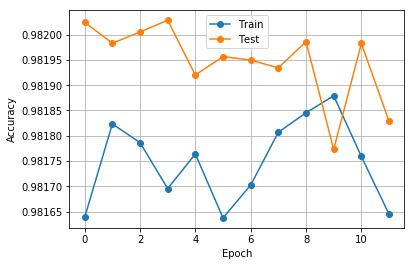

In [38]:
plt.plot(hist.history['acc'], 'o-')
plt.plot(hist.history['val_acc'], 'o-')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])

In [ ]:
X_test,Y_test=batchmatrix(32,df,test_idx)
scores = new_model.evaluate(X_test, Y_test, verbose=0)